In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchinfo import summary
from torchvision import transforms

from autoencoder import AutoencoderCSVDataset, AutoencoderDirValidationDataset, MNISTAutoencoder

In [2]:
import matplotlib.pyplot as plt

import random

from tqdm.notebook import tqdm
from nguyenpanda.swan import green
import nguyenpanda.crow as crow

from pathlib import Path

In [3]:
plt.style.use('dark_background')

DEVICE = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else
          'cpu')
print(green(DEVICE))

IN_COLAB = crow.nb_utils.is_colab()
print(green(IN_COLAB))

cpu
False


In [4]:
dataset = crow.Dataset('MNIST').alias('/Users/hatuongnguyen/datasets/MNIST_CSV')

Directory "/Users/hatuongnguyen/Learning/PyTorch/model/MNIST_Autoencoder/MNIST" already exists!


In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = AutoencoderCSVDataset(dataset / 'train.csv', train_transform)
test_dataset = AutoencoderCSVDataset(dataset / 'test.csv', test_transform)

print(len(train_dataset), len(test_dataset))

60000 10000


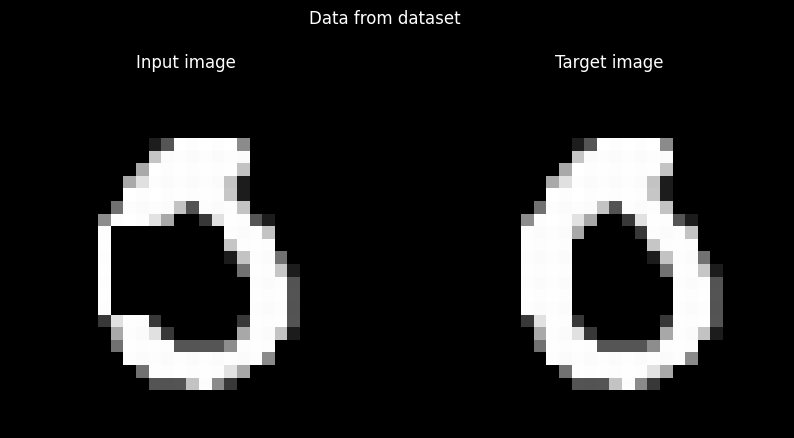

In [6]:
data = train_dataset[random.randint(0, 10000)]

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataset')

ax = plt.subplot(1, 2, 1)
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(data[1].squeeze().to('cpu'), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [7]:
def collate_func(batch_list):
    return tuple(_tensor.to(DEVICE) for _tensor in default_collate(batch_list))


BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func)

batch = next(iter(train_loader))
print(type(batch), len(batch))
print(batch[0].shape)
print(batch[1].shape)

<class 'tuple'> 2
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


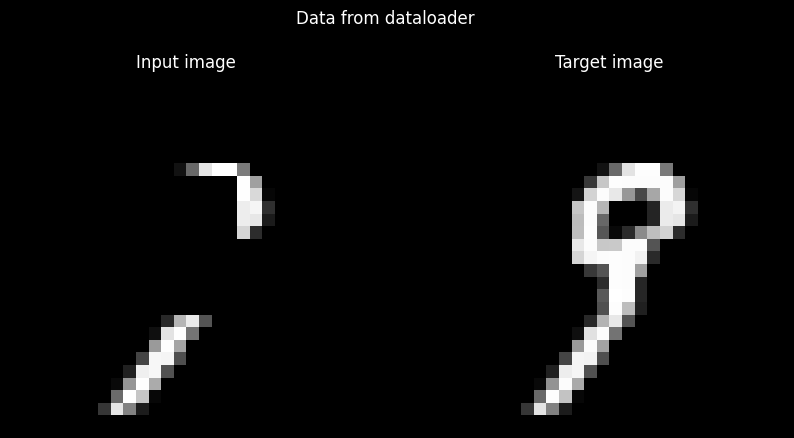

In [8]:
idx = random.randint(0, 31)

fig = plt.figure(figsize=(10, 5))

fig.suptitle('Data from dataloader')

ax = plt.subplot(1, 2, 1)
data = batch[0][idx]
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Input image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
data = batch[1][idx]
ax.imshow(data[0].squeeze().to('cpu'), cmap='gray')
ax.set_title('Target image')
ax.axis('off')

plt.show()

In [9]:
def wrap_value(value):
    return green(f'{value: >8.5f}')


EPOCHS = 50
LEARNING_RATE = 5e-4
HIDDEN_CHANNEL = 40

history = dict(train_loss=[], test_loss=[])
model = MNISTAutoencoder().to(DEVICE)

loss_func = nn.BCEWithLogitsLoss()
opti = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

print('EPOCHS:', green(EPOCHS))
print('LEARNING_RATE:', green(LEARNING_RATE))
print('loss_func:', green(loss_func))
print('opti:', green(opti.__class__.__name__))

summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

EPOCHS: 50
LEARNING_RATE: 0.0005
loss_func: BCEWithLogitsLoss()
opti: Adam


Layer (type:depth-idx)                   Output Shape              Param #
MNISTAutoencoder                         [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 128, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 14, 14]          18,496
│    └─ReLU: 2-5                         [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 7, 7]           73,856
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─Conv2d: 2-8                       [32, 64, 7, 7]            73,792
│    └─ReLU: 2-9                         [32, 64, 7, 7]            --
│    └─Upsample: 2-10                    [32, 64, 14, 14]          --
│ 

In [10]:
MODEL_FILE_NAME = 'zip_unzip.pt'
MODEL_PATH: Path = Path('/content/drive/MyDrive/Colab Notebooks/zip_unzip') if IN_COLAB else Path(Path.cwd() / 'parameter')

_max_test_loss: float = -1

for e in tqdm(range(1, EPOCHS + 1), desc='Epoch: ', total=EPOCHS):
    train_loss = model.train_step(train_loader, loss_func, opti)
    test_loss = model.test_step(test_loader, loss_func)
    print('train_loss = {} | test_loss = {}'.format(
        wrap_value(train_loss), wrap_value(test_loss),
    ))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    if _max_test_loss <= test_loss:
        _max_test_loss = test_loss

        if not MODEL_PATH.is_dir():
            MODEL_PATH.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), MODEL_PATH / MODEL_FILE_NAME)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
print(MODEL_PATH)

model_load = MNISTAutoencoder().to(DEVICE)
model_load.load_state_dict(torch.load(MODEL_PATH / 'google_colab.pt', map_location=torch.device('cpu')))

/Users/hatuongnguyen/Learning/PyTorch/model/MNIST_Autoencoder/parameter


<All keys matched successfully>

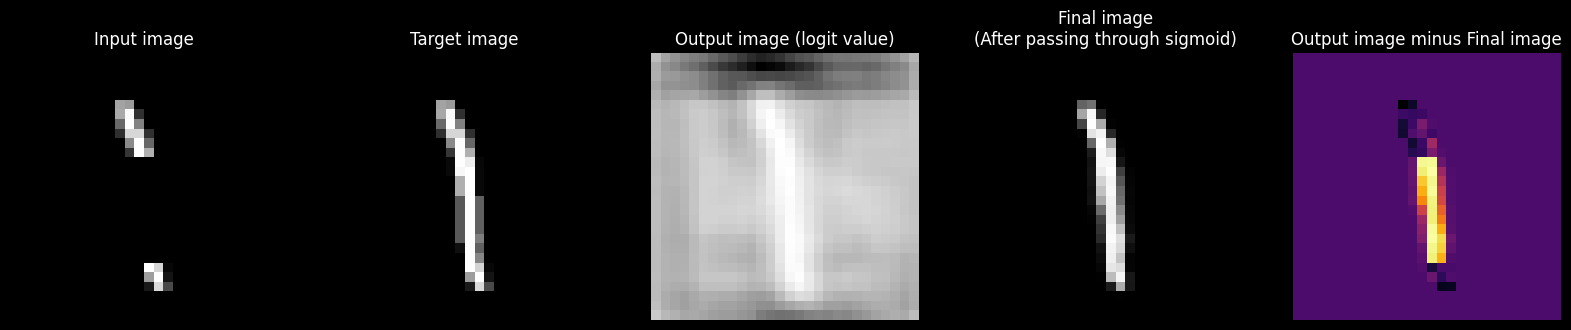

In [12]:
data = [(x, y) for x, y in test_loader]
batch = random.randint(0, len(test_loader) - 1)
idx = random.randint(0, BATCH_SIZE - 1)

x, y = data[batch]

plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 5, 1)
miss = x[idx]
ax.imshow(miss[0].squeeze().to('cpu'), cmap='gray')
ax.axis('off')
ax.set_title('Input image')

ax = plt.subplot(1, 5, 2)
tar = y[idx]
ax.imshow(tar[0].squeeze().to('cpu'), cmap='gray')
ax.axis('off')
ax.set_title('Target image')

ax = plt.subplot(1, 5, 3)
model_load.eval()
with torch.inference_mode():
    output = model_load(x[idx].unsqueeze(dim=0))
ax.imshow(output.squeeze().to('cpu'), cmap='gray')
ax.axis('off')
ax.set_title('Output image (logit value)')

ax = plt.subplot(1, 5, 4)
output = torch.sigmoid(output)
ax.imshow(output.squeeze().to('cpu'), cmap='gray')
ax.axis('off')
ax.set_title('Final image\n(After passing through sigmoid)')

ax = plt.subplot(1, 5, 5)
delta = output - miss
ax.imshow(delta.squeeze().to('cpu'), cmap='inferno')
ax.axis('off')
ax.set_title('Output image minus Final image')

plt.show()

In [13]:
VALIDATION_PATH: Path = Path.cwd() / 'validation'
print(VALIDATION_PATH)

/Users/hatuongnguyen/Learning/PyTorch/model/MNIST_Autoencoder/validation


In [41]:
validation_dataset = AutoencoderDirValidationDataset(VALIDATION_PATH, train_transform)

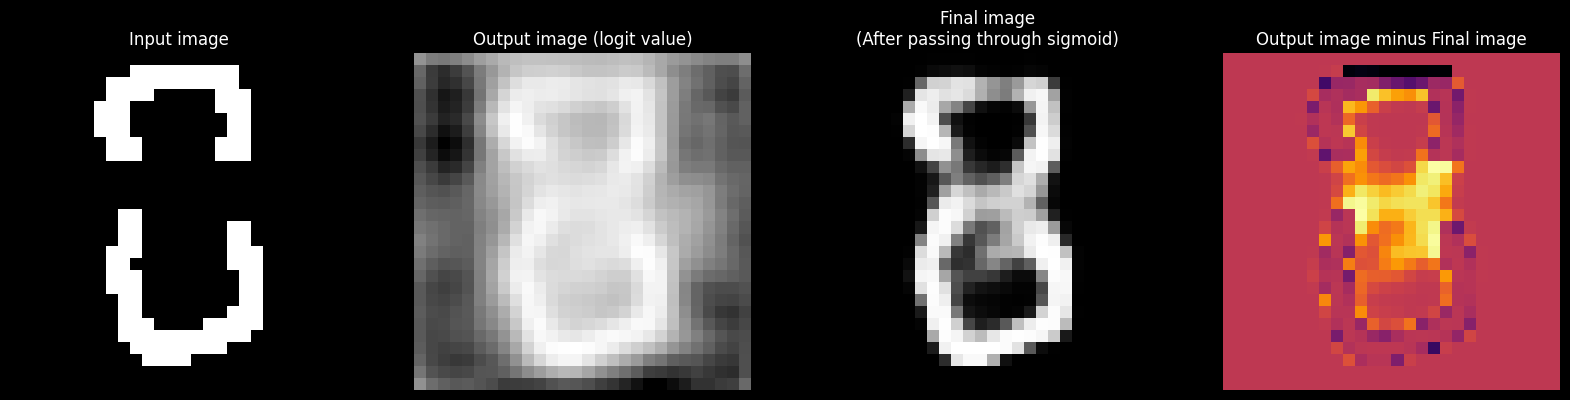

In [50]:
idx = random.randint(0, len(validation_dataset) - 1)
img = validation_dataset[idx].unsqueeze(dim=0)

plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 4, 1)
ax.imshow(img.squeeze().numpy(), cmap='gray')
ax.axis('off')
ax.set_title('Input image')

ax = plt.subplot(1, 4, 2)
model_load.eval()
with torch.inference_mode():
    logit_img = model_load(img)
ax.imshow(logit_img.squeeze().numpy(), cmap='gray')
ax.axis('off')
ax.set_title('Output image (logit value)')

ax = plt.subplot(1, 4, 3)
tar = torch.sigmoid(logit_img)
ax.imshow(tar.squeeze().numpy(), cmap='gray')
ax.axis('off')
ax.set_title('Final image\n(After passing through sigmoid)')

ax = plt.subplot(1, 4, 4)
delta = tar - img
ax.imshow(delta.squeeze().numpy(), cmap='inferno')
ax.axis('off')
ax.set_title('Output image minus Final image')

plt.show()